### 0. 초기 설정
- drive mount
- import modules
- gpu 연결
- 데이터 폴더 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/DA28_pj03_3')
from weather_setting import mySplitFP, mycreateDataset, mysetting
from NN_train import train

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import random_split
from torchvision import datasets 
from torchvision import transforms 
from torch.utils.data import Dataset
import glob
from PIL import Image # Image.open(path)
import cv2
import pandas as pd
import albumentations as A # trochvision transforms 보다 빠름(label도 같이 변환가능)
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
!pip install kaggle
from google.colab import files
files.upload() 

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ammaralfaifi/5class-weather-status-image-classification
!unzip -q 5class-weather-status-image-classification.zip -d weather

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
100% 498M/498M [00:22<00:00, 23.2MB/s]
100% 498M/498M [00:22<00:00, 23.7MB/s]


### 1. 데이터 전처리
- train, valid, test 나누기
- label= 0: cat / 1: dog

In [114]:
root = './weather/data/'
labels_map = {0:'cloudy', 1:'foggy', 2:'rainy', 3:'snowy', 4:'sunny'}

transform1 = A.Compose([A.Resize(224,224),
                       A.Normalize(),
                       A.HorizontalFlip(p=0.3),
                       ToTensorV2()])
transform2 = transforms.Compose([transforms.Resize([224, 224]), 
                                transforms.RandomHorizontalFlip(p=0.3),
                                transforms.ToTensor()])

mydata = mysetting(root, labels_map)
mydata.getDataset(transform1, using='A')
# mydata2 = mysetting(root, labels_map; mydata2.getDataset(transform2)

train, valid, test: 11723 2705 3611


In [115]:
batch_s = 16
mydata.getDataloader(batch_s)
trainloader, validloader, testloader = mydata.trainloader, mydata.validloader, mydata.testloader

train, valid, test: 733 170 226
trainloader shape torch.Size([16, 3, 224, 224]) torch.Size([16])


### 2. 시각화

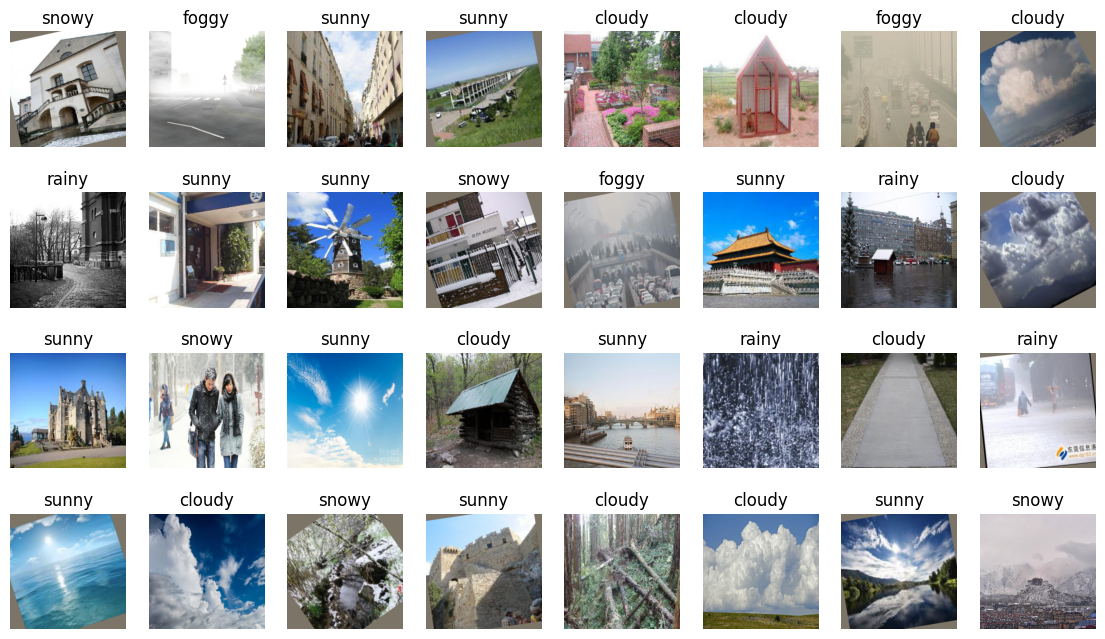

In [112]:
mydata.showimg()

### 3. model 설정

In [116]:
# https://github.com/pytorch/vision/tree/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models
model = models.resnet101(weights=True)

for parameter in model.parameters():
    parameter.requires_grad = False 

# model # find last classifier block name

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [117]:
for parameter in model.fc.parameters(): # classifier bolck: fc
    parameter.requires_grad = True 
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [118]:
model.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Linear(512,5))
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=5, bias=True)
)

### 4. 학습하기

In [119]:
lr = 0.001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=lr) # optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN = train(model, loss_fn, optimizer, trainloader, validloader, testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN.train_loop()

Epoch : 1/55....... Train Loss : 0.617 Valid Loss : 0.446 Valid Accuracy : 0.822
Epoch : 2/55....... Train Loss : 0.461 Valid Loss : 0.425 Valid Accuracy : 0.833
Epoch : 3/55....... Train Loss : 0.404 Valid Loss : 0.439 Valid Accuracy : 0.832
Epoch : 4/55....... Train Loss : 0.374 Valid Loss : 0.428 Valid Accuracy : 0.844
Epoch : 5/55....... Train Loss : 0.324 Valid Loss : 0.397 Valid Accuracy : 0.850
Epoch : 6/55....... Train Loss : 0.310 Valid Loss : 0.411 Valid Accuracy : 0.843
Epoch : 7/55....... Train Loss : 0.288 Valid Loss : 0.441 Valid Accuracy : 0.838
Epoch : 8/55....... Train Loss : 0.272 Valid Loss : 0.465 Valid Accuracy : 0.833
Epoch : 9/55....... Train Loss : 0.249 Valid Loss : 0.440 Valid Accuracy : 0.855
Epoch : 10/55....... Train Loss : 0.228 Valid Loss : 0.425 Valid Accuracy : 0.847
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.
Epoch : 11/55....... Train Loss : 0.168 Valid Loss : 0.394 Valid Accuracy : 0.857
Epoch : 12/55....... Train Loss : 0.158 Valid

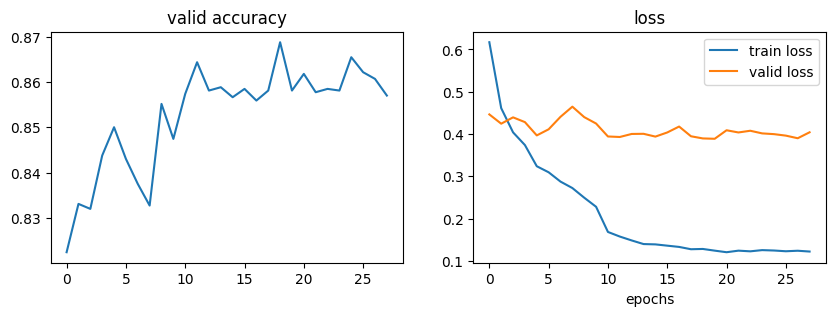

In [120]:
myNN.result_plot()

### 5. 결과 예측

In [123]:
# myNN.check(unsq=True, rnd_idx=10)

### 6. test data 적용

In [124]:
myNN.evaluate(valid=False)

(0.37730381748251685, 0.8661504424778761)

In [125]:
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)

test loss: 0.379
test accuracy: 0.860


### 7. 모델 저장

In [126]:
torch.save(model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)

test loss: 0.377
test accuracy: 0.864


In [127]:
myNN.load_model(dirct='best_checkpoint.pth', model=model)

test loss: 0.381
test accuracy: 0.857


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1/55....... Train Loss : 0.704 Valid Loss : 0.502 Valid Accuracy : 0.811
Epoch : 2/55....... Train Loss : 0.523 Valid Loss : 0.501 Valid Accuracy : 0.810
Epoch : 3/55....... Train Loss : 0.466 Valid Loss : 0.480 Valid Accuracy : 0.815
Epoch : 4/55....... Train Loss : 0.433 Valid Loss : 0.474 Valid Accuracy : 0.817
Epoch : 5/55....... Train Loss : 0.401 Valid Loss : 0.453 Valid Accuracy : 0.830
Epoch : 6/55....... Train Loss : 0.379 Valid Loss : 0.474 Valid Accuracy : 0.825
Epoch : 7/55....... Train Loss : 0.350 Valid Loss : 0.456 Valid Accuracy : 0.849
Epoch : 8/55....... Train Loss : 0.334 Valid Loss : 0.526 Valid Accuracy : 0.821
Epoch : 9/55....... Train Loss : 0.320 Valid Loss : 0.502 Valid Accuracy : 0.829
Epoch : 10/55....... Train Loss : 0.305 Valid Loss : 0.459 Valid Accuracy : 0.835
Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.
Epoch : 11/55....... Train Loss : 0.225 Valid Loss : 0.432 Valid Accuracy : 0.845
Epoch : 12/55....... Train Loss : 0.207 Valid

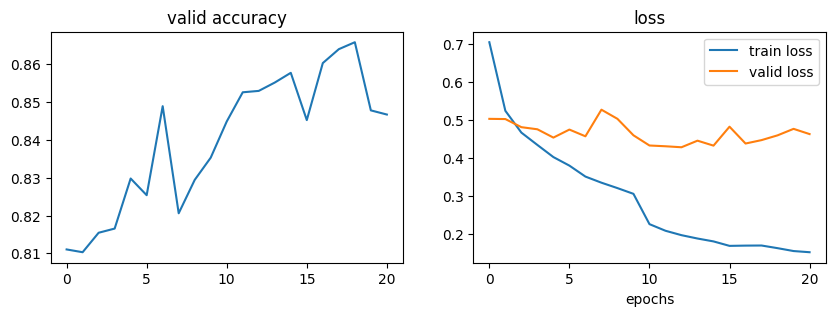

test loss: 0.385
test accuracy: 0.864
test loss: 0.384
test accuracy: 0.860
test loss: 0.435
test accuracy: 0.853


In [128]:
model2 = models.resnet101(weights=True)
for parameter in model2.parameters():
    parameter.requires_grad = False 
for parameter in model2.fc.parameters():
    parameter.requires_grad = True 
model2.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Linear(512,5))
lr = 0.01; patience = 7; epochs = 55
model2 = model2.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model2.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN2 = train(model2, loss_fn, optimizer, trainloader, validloader, testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN2.train_loop()
myNN2.result_plot()
# myNN.check(unsq=True, rnd_idx=10)


In [133]:
myNN2.evaluation(myNN2.model, myNN2.testloader, myNN2.loss_fn)
# torch.save(model.state_dict(), 'last_checkpoint.pth')
# myNN2.load_model(dirct='last_checkpoint.pth', model=model2)
# myNN2.load_model(dirct='best_checkpoint.pth', model=model2)

test loss: 1.441
test accuracy: 0.616


In [130]:
model3 = models.resnet152(weights=True)
for parameter in model3.parameters():
    parameter.requires_grad = False 
for parameter in model3.fc.parameters():
    parameter.requires_grad = True 
model3.fc

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=1000, bias=True)

Epoch : 1/55....... Train Loss : 0.611 Valid Loss : 0.523 Valid Accuracy : 0.795
Epoch : 2/55....... Train Loss : 0.480 Valid Loss : 0.456 Valid Accuracy : 0.815
Epoch : 3/55....... Train Loss : 0.422 Valid Loss : 0.464 Valid Accuracy : 0.815
Epoch : 4/55....... Train Loss : 0.377 Valid Loss : 0.440 Valid Accuracy : 0.831
Epoch : 5/55....... Train Loss : 0.342 Valid Loss : 0.463 Valid Accuracy : 0.825
Epoch : 6/55....... Train Loss : 0.324 Valid Loss : 0.449 Valid Accuracy : 0.844
Epoch : 7/55....... Train Loss : 0.295 Valid Loss : 0.441 Valid Accuracy : 0.846
Epoch : 8/55....... Train Loss : 0.279 Valid Loss : 0.583 Valid Accuracy : 0.799
Epoch : 9/55....... Train Loss : 0.256 Valid Loss : 0.420 Valid Accuracy : 0.843
Epoch : 10/55....... Train Loss : 0.237 Valid Loss : 0.439 Valid Accuracy : 0.834
Epoch : 11/55....... Train Loss : 0.229 Valid Loss : 0.448 Valid Accuracy : 0.844
Epoch : 12/55....... Train Loss : 0.216 Valid Loss : 0.471 Valid Accuracy : 0.831
Epoch : 13/55....... Trai

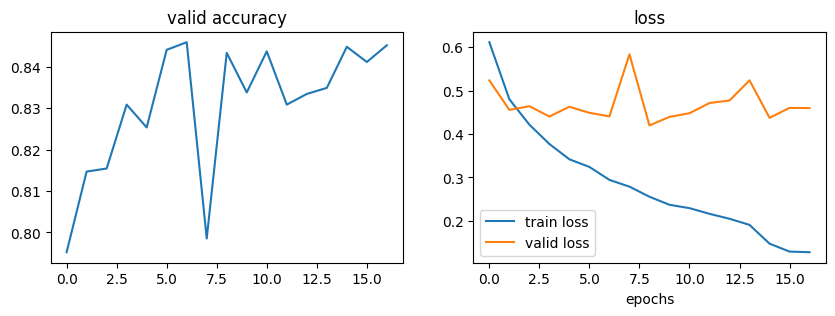

test loss: 0.377
test accuracy: 0.864
test loss: 0.375
test accuracy: 0.865


RuntimeError: ignored

In [131]:
model3.fc = nn.Sequential(nn.Linear(2048,512),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.Linear(512,5))
lr = 0.001; patience = 7; epochs = 55
model3 = model3.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model3.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN3 = train(model3, loss_fn, optimizer, trainloader, validloader, testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN3.train_loop()
myNN3.result_plot()
# myNN.check(unsq=True, rnd_idx=10)
myNN3.evaluation(myNN3.model, myNN3.testloader, myNN3.loss_fn)
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [134]:
# myNN3.load_model(dirct='last_checkpoint.pth', model=model3)
# myNN3.load_model(dirct='best_checkpoint.pth', model=model3)

Epoch : 1/55....... Train Loss : 0.698 Valid Loss : 0.673 Valid Accuracy : 0.731
Epoch : 2/55....... Train Loss : 0.523 Valid Loss : 0.488 Valid Accuracy : 0.805
Epoch : 3/55....... Train Loss : 0.469 Valid Loss : 0.480 Valid Accuracy : 0.810
Epoch : 4/55....... Train Loss : 0.432 Valid Loss : 0.463 Valid Accuracy : 0.823
Epoch : 5/55....... Train Loss : 0.410 Valid Loss : 0.595 Valid Accuracy : 0.788
Epoch : 6/55....... Train Loss : 0.390 Valid Loss : 0.463 Valid Accuracy : 0.818
Epoch : 7/55....... Train Loss : 0.368 Valid Loss : 0.586 Valid Accuracy : 0.800
Epoch : 8/55....... Train Loss : 0.352 Valid Loss : 0.513 Valid Accuracy : 0.823
Epoch : 9/55....... Train Loss : 0.323 Valid Loss : 0.448 Valid Accuracy : 0.838
Epoch : 10/55....... Train Loss : 0.314 Valid Loss : 0.590 Valid Accuracy : 0.803
Epoch : 11/55....... Train Loss : 0.310 Valid Loss : 0.488 Valid Accuracy : 0.815
Epoch : 12/55....... Train Loss : 0.300 Valid Loss : 0.581 Valid Accuracy : 0.821
Epoch : 13/55....... Trai

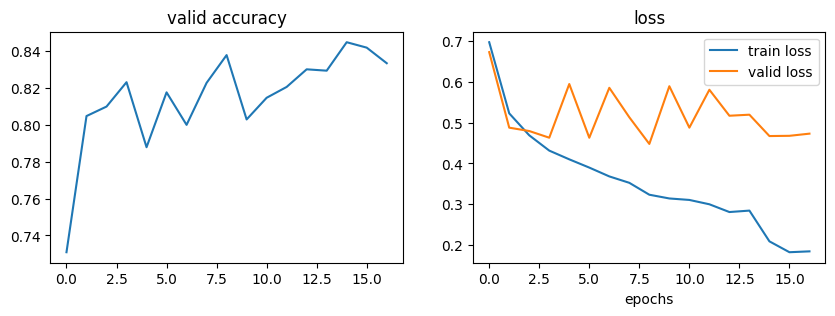

test loss: 0.450
test accuracy: 0.853
test loss: 0.448
test accuracy: 0.849
test loss: 0.439
test accuracy: 0.845


In [136]:
model4 = models.resnet152(weights=True)
for parameter in model4.parameters():
    parameter.requires_grad = False 
for parameter in model4.fc.parameters():
    parameter.requires_grad = True 
model4.fc = nn.Sequential(nn.Linear(2048,512),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.Linear(512,5))
lr = 0.01; patience = 7; epochs = 55
model4 = model4.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model4.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN4 = train(model4, loss_fn, optimizer, trainloader, validloader, testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN4.train_loop()
myNN4.result_plot()
# myNN.check(unsq=True, rnd_idx=10)
myNN4.evaluation(myNN4.model, myNN4.testloader, myNN4.loss_fn)
torch.save(myNN4.model.state_dict(), 'last_checkpoint.pth')
myNN4.load_model(dirct='last_checkpoint.pth', model=model4)
myNN4.load_model(dirct='best_checkpoint.pth', model=model4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1/55....... Train Loss : 0.652 Valid Loss : 0.515 Valid Accuracy : 0.790
Epoch : 2/55....... Train Loss : 0.512 Valid Loss : 0.476 Valid Accuracy : 0.808
Epoch : 3/55....... Train Loss : 0.460 Valid Loss : 0.468 Valid Accuracy : 0.815
Epoch : 4/55....... Train Loss : 0.434 Valid Loss : 0.476 Valid Accuracy : 0.806
Epoch : 5/55....... Train Loss : 0.410 Valid Loss : 0.442 Valid Accuracy : 0.832
Epoch : 6/55....... Train Loss : 0.396 Valid Loss : 0.425 Valid Accuracy : 0.841
Epoch : 7/55....... Train Loss : 0.372 Valid Loss : 0.431 Valid Accuracy : 0.829
Epoch : 8/55....... Train Loss : 0.351 Valid Loss : 0.432 Valid Accuracy : 0.835
Epoch : 9/55....... Train Loss : 0.341 Valid Loss : 0.426 Valid Accuracy : 0.831
Epoch : 10/55....... Train Loss : 0.324 Valid Loss : 0.391 Valid Accuracy : 0.853
Epoch : 11/55....... Train Loss : 0.311 Valid Loss : 0.416 Valid Accuracy : 0.837
Epoch : 12/55....... Train Loss : 0.303 Valid Loss : 0.391 Valid Accuracy : 0.847
Epoch : 13/55....... Trai

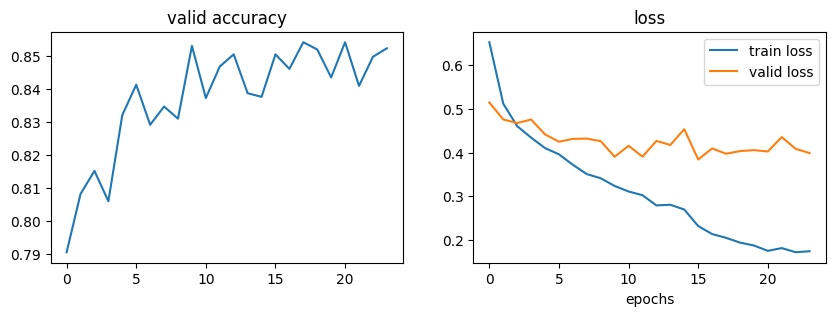

test loss: 0.365
test accuracy: 0.865
test loss: 0.361
test accuracy: 0.865
test loss: 0.361
test accuracy: 0.860


In [137]:
model5 = models.resnet152(weights=True)
for parameter in model5.parameters():
    parameter.requires_grad = False 
for parameter in model5.fc.parameters():
    parameter.requires_grad = True 
model5.fc = nn.Sequential(nn.Linear(2048,512),
                          nn.BatchNorm1d(512),
                          nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(512,248),
                          nn.BatchNorm1d(248),
                          nn.ReLU(),
                          nn.Linear(248,5))
lr = 0.001; patience = 7; epochs = 55
model5 = model5.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model5.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN5 = train(model5, loss_fn, optimizer, trainloader, validloader, testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN5.train_loop()
myNN5.result_plot()
# myNN.check(unsq=True, rnd_idx=10)
myNN5.evaluation(myNN5.model, myNN5.testloader, myNN5.loss_fn)
torch.save(myNN5.model.state_dict(), 'last_checkpoint.pth')
myNN5.load_model(dirct='last_checkpoint.pth', model=model5)
myNN5.load_model(dirct='best_checkpoint.pth', model=model5)